<a href="https://colab.research.google.com/github/Saria-Alashry/Alashry/blob/%D8%A7%D9%84%D9%83%D9%88%D8%B1%D8%B3-%D8%A7%D9%84%D9%85%D9%81%D8%B5%D9%84-%D9%81%D9%8A-%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A-%D9%88%D9%85%D8%B3%D8%A7%D8%A8%D9%82%D8%A9-%D8%A8%D8%B1%D9%85%D8%AC%D8%A9-50-%D8%A7%D9%84%D9%81-%D8%AC%D9%86%D9%8A%D9%87/Week5_Part3_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 Part 3: Cross-Validation & Learning Rate Tuning

**Instructor:** Dr. Mahmoud Eid (m.eid@fci-cu.edu.eg)
**Time:** ~2 hours

<div dir="rtl">
<b>النهاردة هنستخدم PyTorch و Cross-Validation عشان نختار أحسن learning rate بإذن الله!</b>
</div>

## Topics
1. Data Splitting Strategy
2. PyTorch Neural Networks
3. Learning Rate Tuning with 5-Fold CV
4. Learning & Validation Curves
5. Final Test Set Evaluation

**Dataset:** Breast Cancer Wisconsin (569 samples, 30 features)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

plt.style.use('dark_background')
np.random.seed(42)
torch.manual_seed(42)

print("✅ Ready!")


✅ Ready!


---
# 1. Data Splitting Strategy

**CRITICAL CONCEPT:** How we split data affects hyperparameter tuning!

**Strategy:**
1. Split 80/20: Training+Validation vs Test
2. Use 5-fold CV on Training+Validation for tuning learning rate
3. **Keep Test set completely untouched** until final evaluation


In [2]:
# Load dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(f"Dataset: Breast Cancer Wisconsin")
print(f"Total samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(np.unique(y))} (binary)")


Dataset: Breast Cancer Wisconsin
Total samples: 569
Features: 30
Classes: 2 (binary)


In [3]:
# Split: Training+Validation (80%) vs Test (20%)
'''
We will use the function: train_test_split
This function takes the following inputs:
X
The full feature matrix (all input variables).
Shape: (n_samples, n_features).

y
The full target vector (labels or regression targets).
Shape: (n_samples,).

test_size=0.2
Proportion of the dataset to allocate to the test set.
Here: 20% test, 80% train/validation.

random_state=42
Seed for the random number generator.
Ensures reproducibility of the split.

stratify=y
Ensures the class distribution in y is preserved in both train and test sets.
Important for classification tasks with imbalanced classes.


Outputs:
X_train_val → 80% of the feature matrix (training/validation set).

X_test → 20% of the feature matrix (test set).

y_train_val → Corresponding labels for the training/validation set.

y_test → Corresponding labels for the test set.
'''
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  # note that this is a single split and not a cross-validation

print(f"\nData split:")
print(f"  Training+Validation: {X_train_val.shape[0]} samples")
print(f"  External Test Set:   {X_test.shape[0]} samples")
print(f"\nTest set will NOT be used during hyperparameter tuning!")



Data split:
  Training+Validation: 455 samples
  External Test Set:   114 samples

Test set will NOT be used during hyperparameter tuning!


---
# 2. PyTorch Neural Network

Simple architecture:
- **Input:** 30 features
- **Hidden:** 64 neurons + ReLU
- **Output:** 2 neurons (softmax applied in CrossEntropyLoss)


In [4]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=30, hidden_size=15, num_classes=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create model
model = SimpleNN()
print("Architecture:")
print(model)
print(f"\nParameters: {sum(p.numel() for p in model.parameters()):,}")


Architecture:
SimpleNN(
  (fc1): Linear(in_features=30, out_features=15, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=15, out_features=2, bias=True)
)

Parameters: 497


---
# 3. Training Function

Returns **learning & validation curves** for every epoch.


In [5]:
def train_model(model, X_train, y_train, X_val, y_val, lr, epochs=100):
    """
    Train model and return learning & validation curves

    Returns:
        train_losses, val_losses, train_accs, val_accs
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, train_pred = torch.max(outputs, 1)
        train_acc = (train_pred == y_train).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_pred = torch.max(val_outputs, 1)
            val_acc = (val_pred == y_val).float().mean().item()

        val_losses.append(val_loss.item())
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

print("Training function defined")


Training function defined


---
# 4. Learning Rate Tuning with 5-Fold CV with a validation curve

We'll test 5 different learning rates and use cross-validation to find the best one.


In [6]:
# Learning rates to test
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

print(f"Testing {len(learning_rates)} learning rates with 5-fold CV...")
print(f"Total models: {len(learning_rates)} × 5 = 25")


import random
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def set_all_seeds(seed):
    # notice how we can use a function like this one to fix all seeds when working with many
    # random variables and need to fix the seed we can make a function like this one
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

FIXED_SEED = 42
set_all_seeds(FIXED_SEED)

lr_results = {}

# Cross-validation for all learning rates
for lr in learning_rates:
    print(f"\nTesting LR = {lr}...")

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_val_accs = []
    fold_train_accs = []
    fold_val_curves = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val), 1):
        X_train_fold = X_train_val[train_idx]
        y_train_fold = y_train_val[train_idx]
        X_val_fold = X_train_val[val_idx]
        y_val_fold = y_train_val[val_idx]

        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        X_train_tensor = torch.FloatTensor(X_train_fold)
        y_train_tensor = torch.LongTensor(y_train_fold)
        X_val_tensor = torch.FloatTensor(X_val_fold)
        y_val_tensor = torch.LongTensor(y_val_fold)

        model_fold = SimpleNN()
        train_losses, val_losses, train_accs, val_accs = train_model(
            model_fold, X_train_tensor, y_train_tensor,
            X_val_tensor, y_val_tensor, lr=lr, epochs=100
        )

        fold_val_accs.append(val_accs[-1])
        fold_train_accs.append(train_accs[-1])
        fold_val_curves.append(val_accs)

    mean_acc = np.mean(fold_val_accs)
    std_acc = np.std(fold_val_accs)
    mean_train_acc = np.mean(fold_train_accs)

    lr_results[lr] = {
        'mean_acc': mean_acc,
        'std_acc': std_acc,
        'mean_train_acc': mean_train_acc,
        'fold_accs': fold_val_accs,
        'fold_train_accs': fold_train_accs,
        'val_curves': fold_val_curves
    }

    print(f"  Mean: {mean_acc:.4f} ± {std_acc:.4f}")

print("\n Cross-validation complete!")



Testing 5 learning rates with 5-fold CV...
Total models: 5 × 5 = 25

Testing LR = 0.0001...
  Mean: 0.7253 ± 0.1297

Testing LR = 0.0005...
  Mean: 0.9341 ± 0.0184

Testing LR = 0.001...
  Mean: 0.9626 ± 0.0256

Testing LR = 0.005...
  Mean: 0.9736 ± 0.0179

Testing LR = 0.01...
  Mean: 0.9802 ± 0.0108

 Cross-validation complete!



Extracting mean scores for Validation Curve...
Best Learning Rate found: 0.01


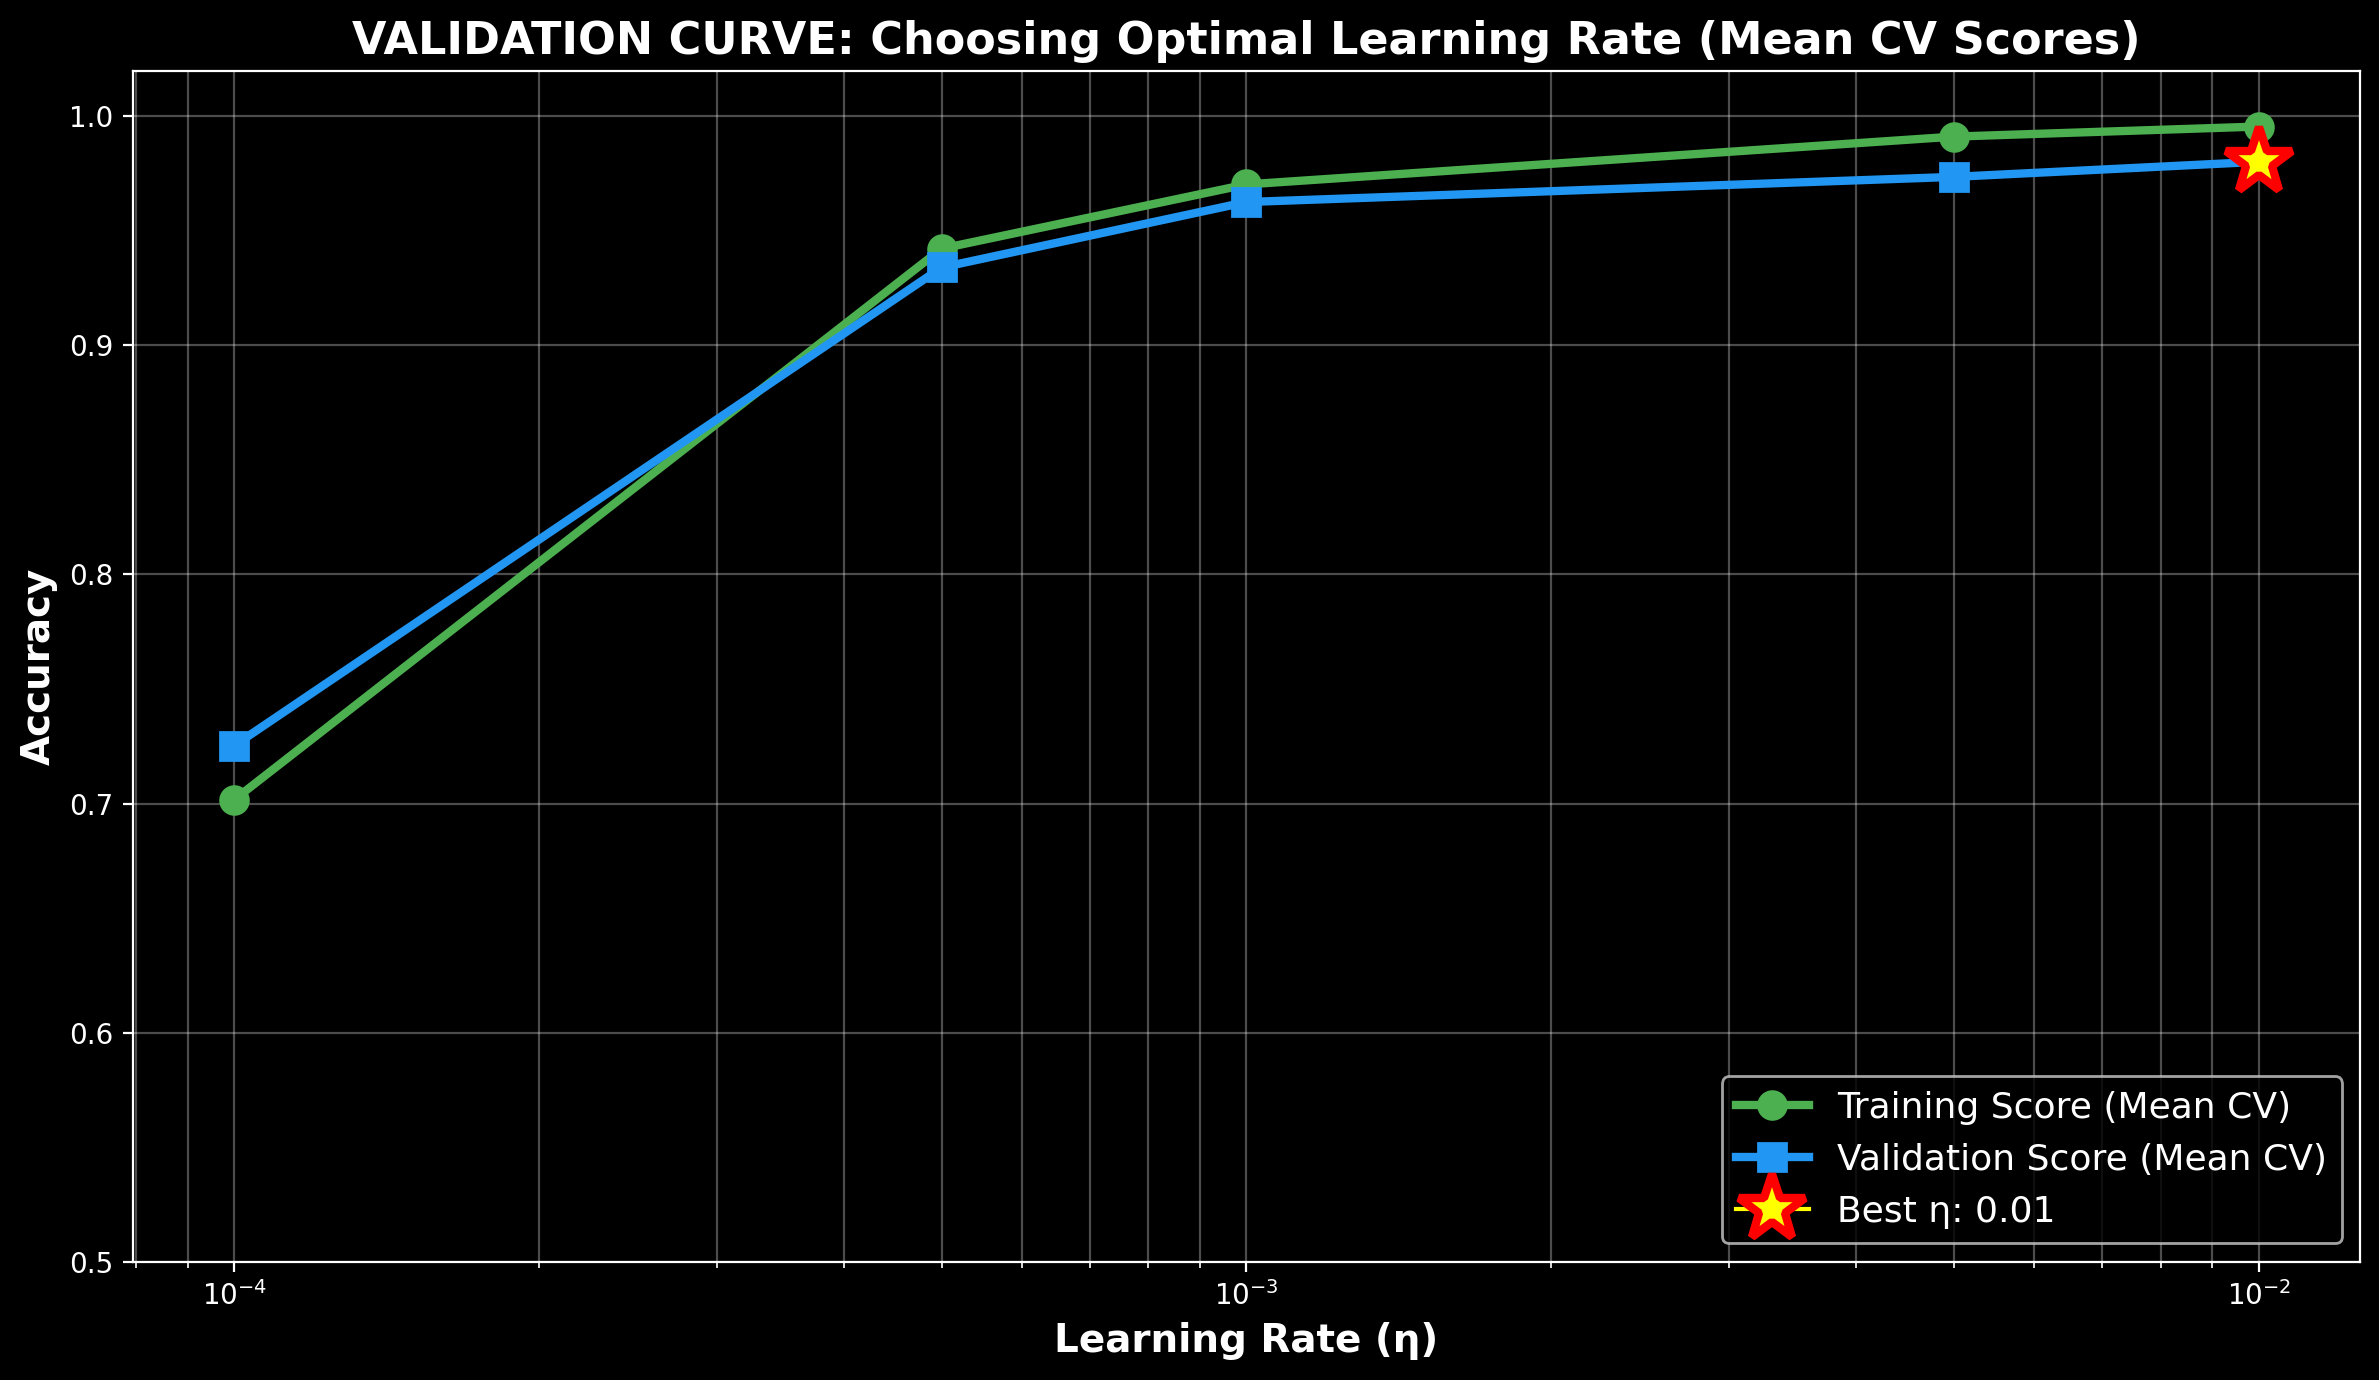

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# VALIDATION CURVE: X=learning rate η, Y=accuracy
print("\nExtracting mean scores for Validation Curve...")

# Extract mean scores from the lr_results generated in the previous cell
train_scores_vc = [lr_results[lr]['mean_train_acc'] for lr in learning_rates]
val_scores_vc = [lr_results[lr]['mean_acc'] for lr in learning_rates]

# Determine the best learning rate based on mean validation accuracy
best_lr = max(lr_results, key=lambda lr: lr_results[lr]['mean_acc'])

print(f"Best Learning Rate found: {best_lr}")

# Plot Validation Curve
fig, ax = plt.subplots(figsize=(12, 7), dpi=200)

ax.plot(learning_rates, train_scores_vc, marker='o', markersize=10,
        label='Training Score (Mean CV)', color='#4CAF50', linewidth=3)
ax.plot(learning_rates, val_scores_vc, marker='s', markersize=10,
        label='Validation Score (Mean CV)', color='#2196F3', linewidth=3)

best_idx = learning_rates.index(best_lr)
ax.plot(best_lr, val_scores_vc[best_idx], marker='*', markersize=25,
        color='yellow', markeredgecolor='red', markeredgewidth=3,
        label=f'Best η: {best_lr}', zorder=10)

ax.set_xlabel('Learning Rate (η)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('VALIDATION CURVE: Choosing Optimal Learning Rate (Mean CV Scores)',
            fontsize=16, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=13, loc='lower right')
ax.grid(alpha=0.3, which='both')
ax.set_ylim([0.5, 1.02])

plt.tight_layout()
plt.show()


---
# 5. Learning Curve


In [8]:
# LEARNING CURVE: X=training samples, Y=accuracy
print("Generating Learning Curve...")

train_sizes = [50, 100, 150, 200, 250, 300, 364]
train_scores_lc = []
val_scores_lc = []

kfold_lc = KFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(kfold_lc.split(X_train_val))

X_train_full = X_train_val[train_idx]
y_train_full = y_train_val[train_idx]
X_val_lc = X_train_val[val_idx]
y_val_lc = y_train_val[val_idx]

for size in train_sizes:
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    scaler_lc = StandardScaler()
    X_train_scaled = scaler_lc.fit_transform(X_train_subset) # notice when we standardize using fit_transform the mean and std are claculated and applied (data is z-scored)
    # but with validation we transform directly because we already calculated the mean and std using training
    X_val_scaled = scaler_lc.transform(X_val_lc)

    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train_subset)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val_lc)

    model_lc = SimpleNN()
    _, _, train_accs, val_accs = train_model(
        model_lc, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor, lr=best_lr, epochs=100
    )

    train_scores_lc.append(train_accs[-1])
    val_scores_lc.append(val_accs[-1])

print("Learning curve generated")


Generating Learning Curve...
Learning curve generated


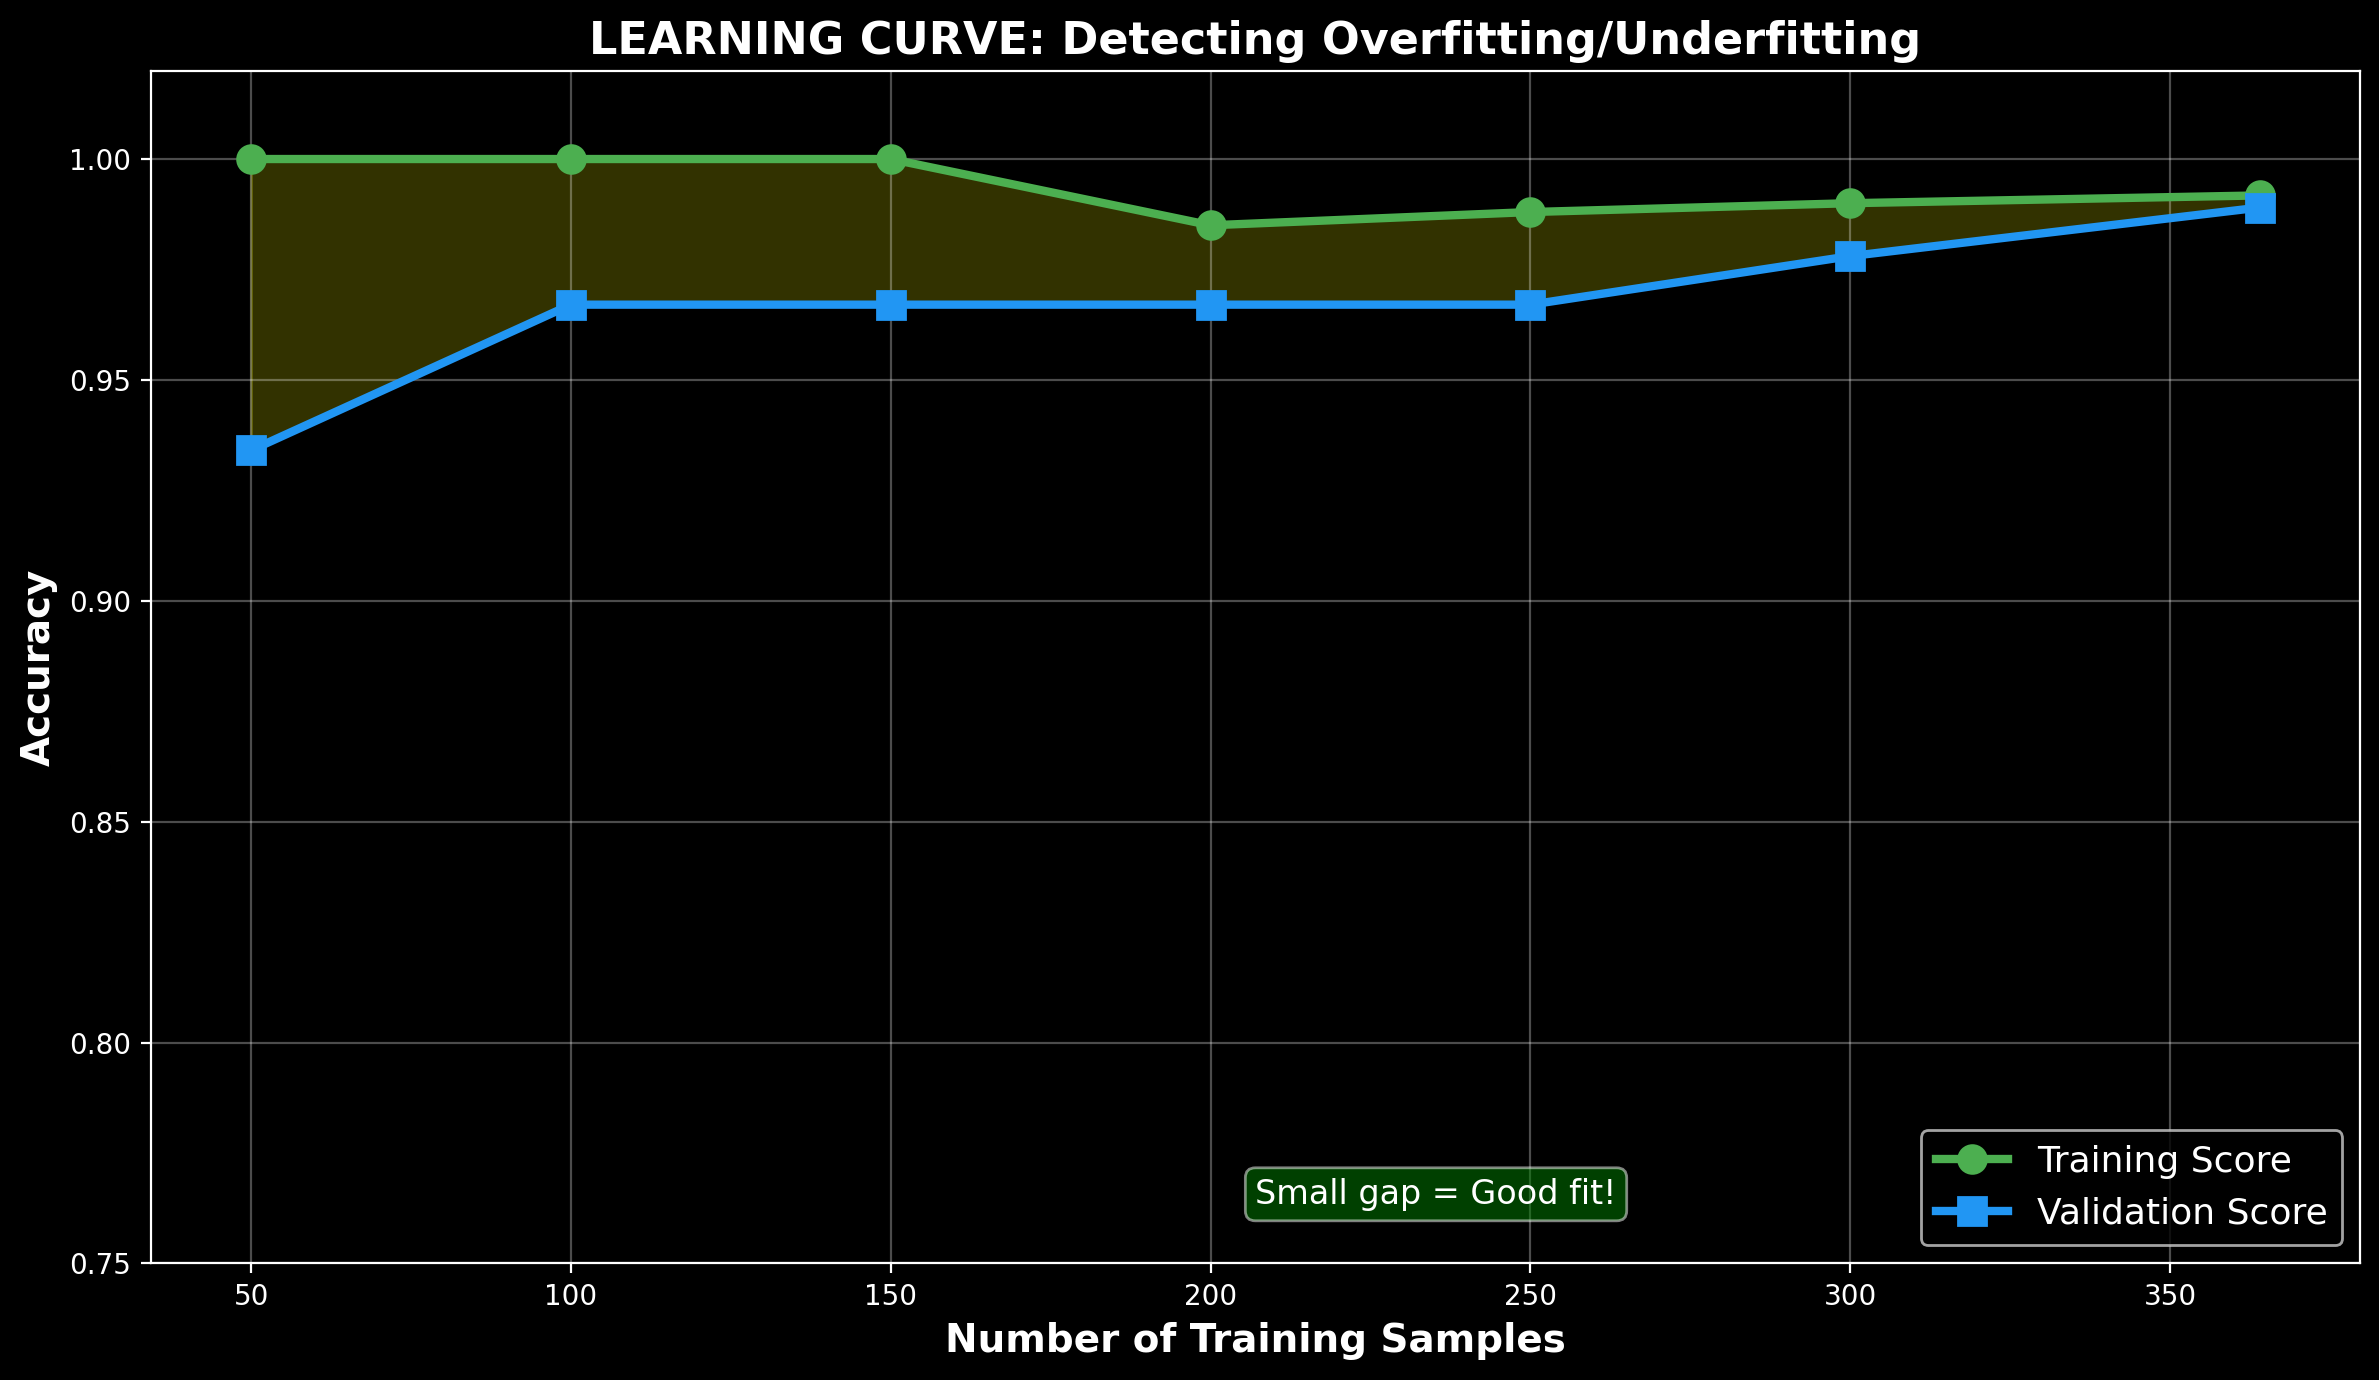

In [9]:
# Plot Learning Curve
fig, ax = plt.subplots(figsize=(12, 7), dpi=200)

ax.plot(train_sizes, train_scores_lc, marker='o', markersize=10,
        label='Training Score', color='#4CAF50', linewidth=3)
ax.plot(train_sizes, val_scores_lc, marker='s', markersize=10,
        label='Validation Score', color='#2196F3', linewidth=3)
ax.fill_between(train_sizes, train_scores_lc, val_scores_lc,
                alpha=0.2, color='yellow')

ax.set_xlabel('Number of Training Samples', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('LEARNING CURVE: Detecting Overfitting/Underfitting',
             fontsize=16, fontweight='bold')
ax.legend(fontsize=13, loc='lower right')
ax.grid(alpha=0.3)
ax.set_ylim([0.75, 1.02])

gap = train_scores_lc[-1] - val_scores_lc[-1]
status = 'Large gap = Overfitting!' if gap > 0.05 else 'Small gap = Good fit!'
color = 'red' if gap > 0.05 else 'green'
ax.text(0.5, 0.05, status, transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))

plt.tight_layout()
plt.show()


### Validation Learning Curves

Now let's see the **learning curves** for each learning rate across all folds.


---
# 6. Final Model Evaluation

Train final model with best learning rate on **all** Training+Validation data.
Then evaluate on the external Test set.


In [10]:
# Prepare data
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

X_train_val_tensor = torch.FloatTensor(X_train_val_scaled)
y_train_val_tensor = torch.LongTensor(y_train_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

print(f"Training final model with best LR = {best_lr}")
print(f"Using all {X_train_val.shape[0]} samples...")


Training final model with best LR = 0.01
Using all 455 samples...


In [11]:
# Train final model
final_model = SimpleNN()

train_losses_final, test_losses_final, train_accs_final, test_accs_final = train_model(
    final_model, X_train_val_tensor, y_train_val_tensor,
    X_test_tensor, y_test_tensor, lr=best_lr, epochs=150
)

print("Training complete!")


Training complete!


In [12]:
# Final evaluation
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_tensor)
    _, test_pred = torch.max(test_outputs, 1)
    final_test_acc = (test_pred == y_test_tensor).float().mean().item()

print(f"\n FINAL TEST ACCURACY: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print("\nThis is the TRUE performance!")



 FINAL TEST ACCURACY: 0.9649 (96.49%)

This is the TRUE performance!


---
## Exercise: Repeat with 10-Fold CV

**Task:** Redo the cross-validation with **10 folds** instead of 5 for LR=0.001


In [14]:
test_lr = 0.001

# YOUR CODE HERE
kfold_10fold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_val_accs_10fold = []

for fold, (train_idx, val_idx) in enumerate(kfold_10fold.split(X_train_val), 1):
    X_train_fold = X_train_val[train_idx]
    y_train_fold = y_train_val[train_idx]
    X_val_fold = X_train_val[val_idx]
    y_val_fold = y_train_val[val_idx]

    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    X_train_tensor = torch.FloatTensor(X_train_fold)
    y_train_tensor = torch.LongTensor(y_train_fold)
    X_val_tensor = torch.FloatTensor(X_val_fold)
    y_val_tensor = torch.LongTensor(y_val_fold)

    model_fold = SimpleNN()
    _, _, _, val_accs = train_model(
        model_fold, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor, lr=test_lr, epochs=100
    )

    fold_val_accs_10fold.append(val_accs[-1])

mean_10fold = np.mean(fold_val_accs_10fold)
std_10fold = np.std(fold_val_accs_10fold)

print(f"\n10-Fold CV Results (LR={test_lr}):")
print(f"  Mean Accuracy: {mean_10fold:.4f} \u00b1 {std_10fold:.4f}")


10-Fold CV Results (LR=0.001):
  Mean Accuracy: 0.9560 ± 0.0454


In [15]:
print("Exercise passed!")


Exercise passed!


---
## Summary

✅ **Data Splitting:**
- Separate test set from beginning
- Use CV only on training+validation data

✅ **Hyperparameter Tuning:**
- Tested 5 learning rates with 5-fold CV
- Chose best based on validation accuracy

✅ **Learning Curves:**
- Visualized training dynamics
- Compared across folds and learning rates

✅ **Final Evaluation:**
- Trained on all available training data
- Evaluated on external test set
